In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load gas line map IC3392_gas_BIN_maps.fits 
gas_path = Path('IC3392_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    V_STARS2 = hdul['V_STARS2'].data
    SIGMA_STARS2 = hdul['SIGMA_STARS2'].data
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from IC3392_gas_BIN_maps_extended.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [3]:
kin_path = Path('IC3392_KIN_maps_extended.fits')
if kin_path.exists():
    print(f"Loading kinematic map from {kin_path}")
    with fits.open(kin_path) as hdul:
        kin_info = hdul.info()
        
        # Read data from all extensions except PRIMARY
        extension_names = [hdul[i].name for i in range(1, len(hdul))]
        print(f"Available extensions: {extension_names}")
        
        # Read each extension's data before closing the file
        for ext_name in extension_names:
            if ext_name and ext_name != "PRIMARY":
                globals()[ext_name] = hdul[ext_name].data
                print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    
    print("All data loaded successfully!")
    hdul.close()
    # Invert the true/false in FOREGROUND_STAR, but except the nan values
    non_FOREGROUND_STAR = np.where(np.isnan(FOREGROUND_STAR), np.nan, ~FOREGROUND_STAR.astype(bool))

    V_STARS2 = np.where(non_FOREGROUND_STAR, V, np.nan)
    SIGMA_STARS2 = np.where(non_FOREGROUND_STAR, SIGMA, np.nan)
    HB4861_FLUX = np.where(non_FOREGROUND_STAR, HB4861_FLUX, np.nan)
    HB4861_FLUX_ERR = np.where(non_FOREGROUND_STAR, HB4861_FLUX_ERR, np.nan)
    HA6562_FLUX = np.where(non_FOREGROUND_STAR, HA6562_FLUX, np.nan)
    HA6562_FLUX_ERR = np.where(non_FOREGROUND_STAR, HA6562_FLUX_ERR, np.nan)
    OIII5006_FLUX = np.where(non_FOREGROUND_STAR, OIII5006_FLUX, np.nan)
    OIII5006_FLUX_ERR = np.where(non_FOREGROUND_STAR, OIII5006_FLUX_ERR, np.nan)
    NII6583_FLUX = np.where(non_FOREGROUND_STAR, NII6583_FLUX, np.nan)
    NII6583_FLUX_ERR = np.where(non_FOREGROUND_STAR, NII6583_FLUX_ERR, np.nan)
    SII6716_FLUX = np.where(non_FOREGROUND_STAR, SII6716_FLUX, np.nan)
    SII6716_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6716_FLUX_ERR, np.nan)
    SII6730_FLUX = np.where(non_FOREGROUND_STAR, SII6730_FLUX, np.nan)
    SII6730_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6730_FLUX_ERR, np.nan)
    print("Foreground stars are removed successfully!")

else:
    print(f"File not found: {kin_path}")

File not found: IC3392_KIN_maps_extended.fits


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_4763/2989348340.py:24: RuntimeWarning: divide by zero encountered in divide
  BD =  HA6562_FLUX / HB4861_FLUX
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_4763/2989348340.py:26: RuntimeWarning: divide by zero encountered in divide
  BD_out = HA6562_FLUX_out / HB4861_FLUX_out


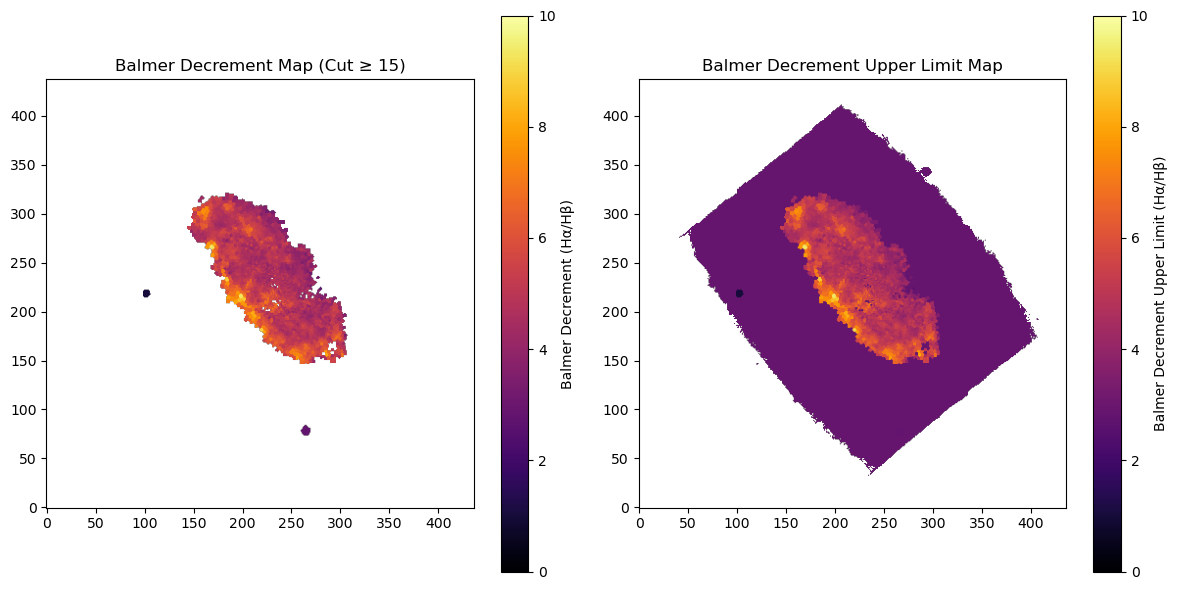

Lowest Balmer Decrement: 1.0401808450211778
Highest Balmer Decrement: 9.36650837704988
Lowest 5 unique non-NaN Balmer Decrement values: [1.04018085 2.65574445 2.82774723 3.09627082 3.22428465]


In [4]:
# Apply a first cut of FLUX/ERR ≥ 5 on every line, 
# at least 22 to get min BD>2.86
# at least 15 to have all SF in BPT diagram
cut = 15
mask_HB = HB4861_FLUX / HB4861_FLUX_ERR >= cut
mask_HA = HA6562_FLUX / HA6562_FLUX_ERR >= cut
# Combine masks for both lines
mask_combined = mask_HB & mask_HA
# Apply the mask to the flux maps
HB4861_FLUX_cut = np.where(mask_combined, HB4861_FLUX, np.nan)
HA6562_FLUX_cut = np.where(mask_combined, HA6562_FLUX, np.nan)
HB4861_FLUX_out = np.where(~mask_combined, HB4861_FLUX, np.nan)
HA6562_FLUX_out = np.where(~mask_combined, HA6562_FLUX, np.nan)
OIII5006_FLUX_cut = np.where(mask_combined, OIII5006_FLUX, np.nan)
OIII5006_FLUX_out = np.where(~mask_combined, OIII5006_FLUX, np.nan)
NII6583_FLUX_cut = np.where(mask_combined, NII6583_FLUX, np.nan)
NII6583_FLUX_out = np.where(~mask_combined, NII6583_FLUX, np.nan)
SII6716_FLUX_cut = np.where(mask_combined, SII6716_FLUX, np.nan)
SII6716_FLUX_out = np.where(~mask_combined, SII6716_FLUX, np.nan)
SII6730_FLUX_cut = np.where(mask_combined, SII6730_FLUX, np.nan)
SII6730_FLUX_out = np.where(~mask_combined, SII6730_FLUX, np.nan)

# Balmer-decrement map – H α/H β (start with all spaxels).
BD =  HA6562_FLUX / HB4861_FLUX
BD_cut = HA6562_FLUX_cut / HB4861_FLUX_cut
BD_out = HA6562_FLUX_out / HB4861_FLUX_out
BD_upper = np.where(~mask_combined & np.isfinite(V_STARS2), 2.86, BD)

# Plot CD_cut map and upper limit BD_upper map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(BD_cut, origin='lower', cmap='inferno', vmin=0, vmax=10,)
plt.colorbar(label='Balmer Decrement (Hα/Hβ)')
plt.title(f'Balmer Decrement Map (Cut ≥ {cut})')
plt.subplot(1, 2, 2)
plt.imshow(BD_upper, origin='lower', cmap='inferno', vmin=0, vmax=10)
plt.colorbar(label='Balmer Decrement Upper Limit (Hα/Hβ)')
plt.title('Balmer Decrement Upper Limit Map')
plt.tight_layout()
plt.show()

# Print the lowest and highest values of the Balmer decrement map
print(f"Lowest Balmer Decrement: {np.nanmin(BD_cut)}")
print(f"Highest Balmer Decrement: {np.nanmax(BD_cut)}")
# Print lowest 5 non-NaN values (unique values only)
bd_valid = BD_cut[np.isfinite(BD_cut)]
bd_unique = np.unique(bd_valid)
lowest_5_unique = bd_unique[:5]
print(f"Lowest 5 unique non-NaN Balmer Decrement values: {lowest_5_unique}")


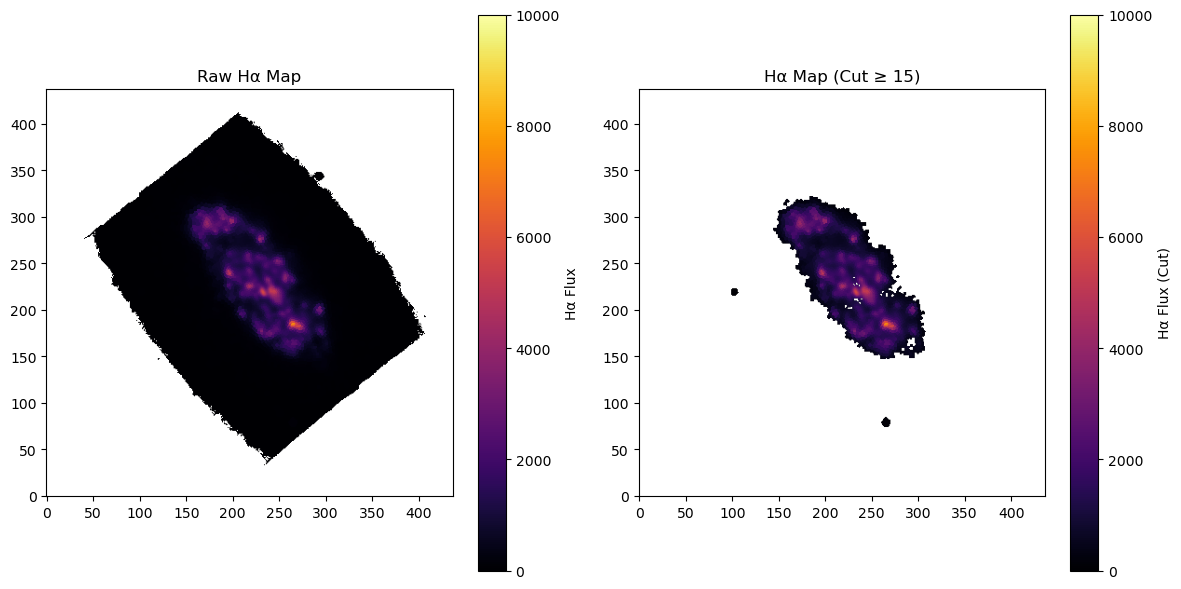

In [5]:
# Plot raw Halpha map and Halpha cut map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', vmin=0, vmax=1e4)
plt.colorbar(label='Hα Flux')
plt.title('Raw Hα Map')
plt.subplot(1, 2, 2)
plt.imshow(HA6562_FLUX_cut, origin='lower', cmap='inferno', vmin=0, vmax=1e4)
plt.colorbar(label='Hα Flux (Cut)')
plt.title(f'Hα Map (Cut ≥ {cut})')
plt.tight_layout()
plt.show()


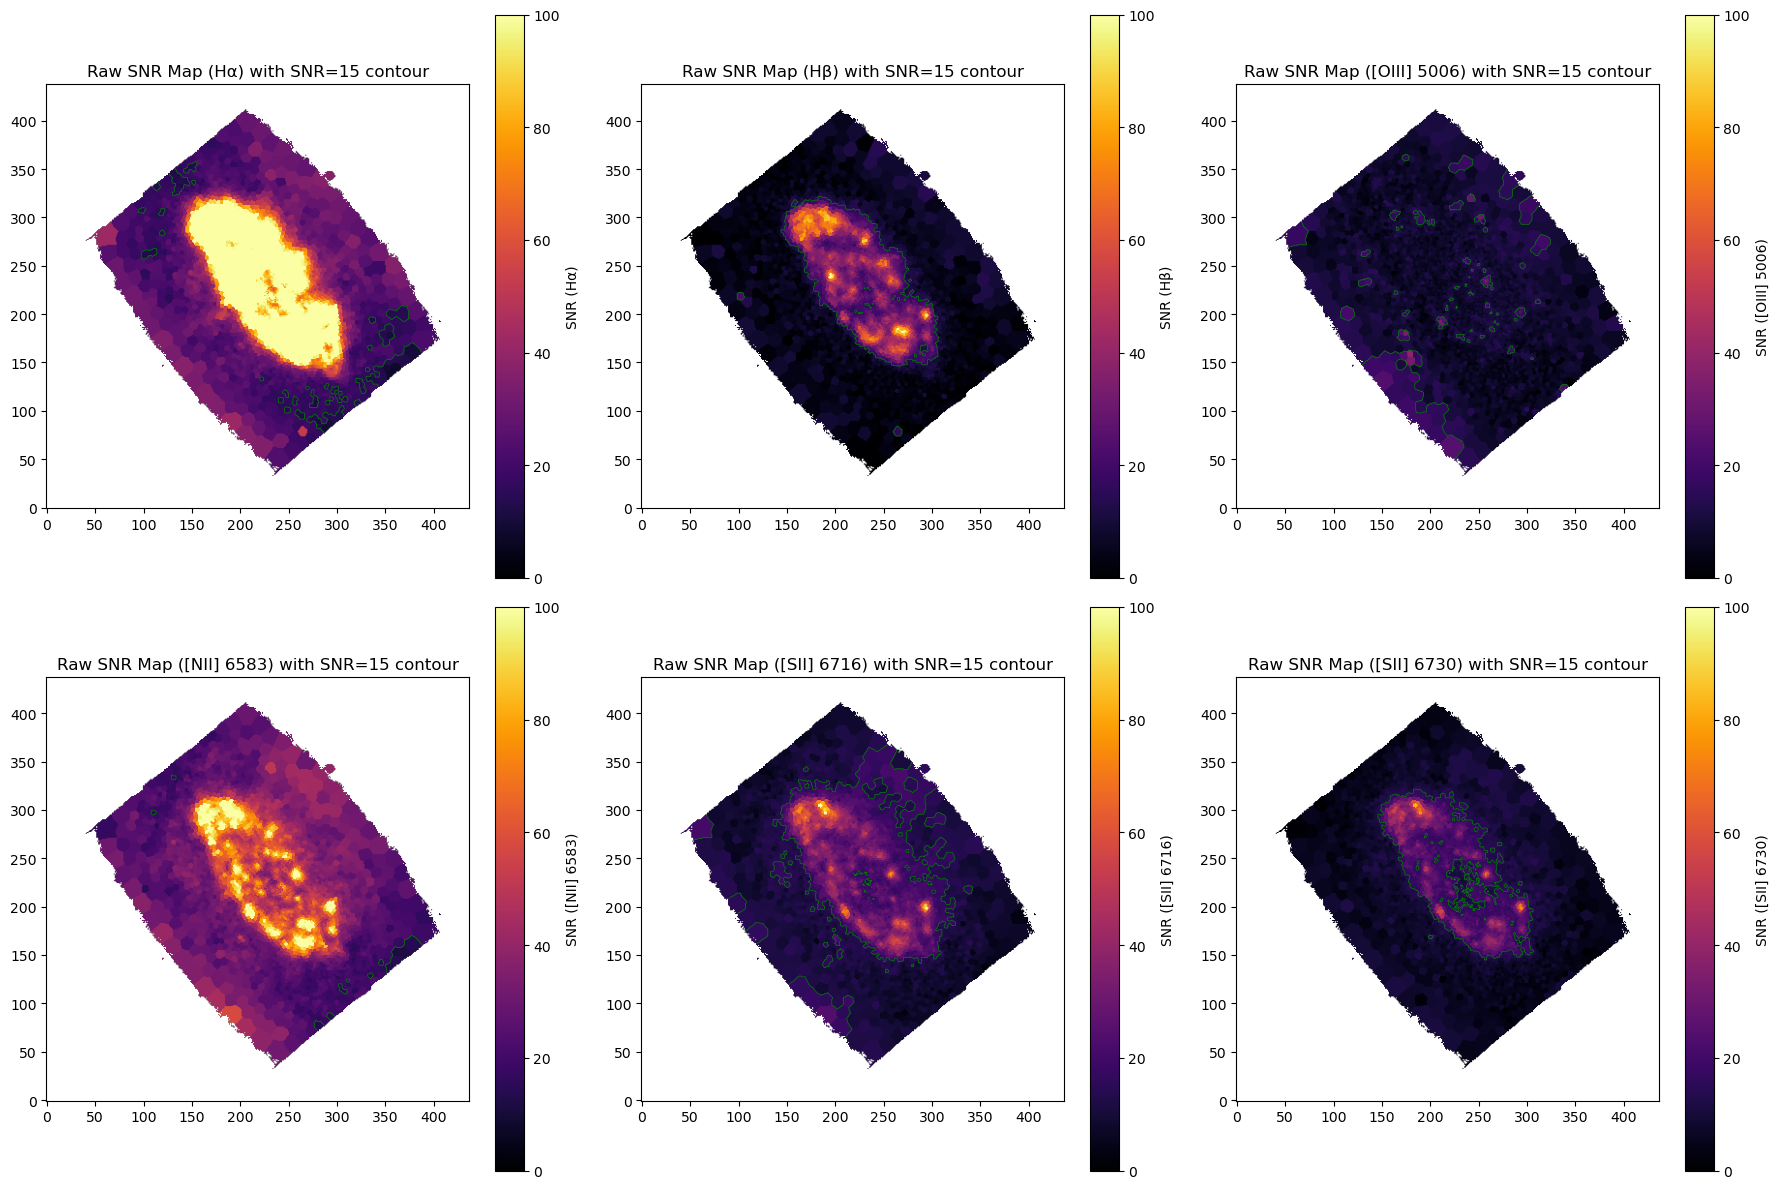

In [6]:
# Plot raw SNR maps for all emission lines with contours at SNR=cut
plt.figure(figsize=(18, 12))

# Hα
plt.subplot(2, 3, 1)
im1 = plt.imshow(HA6562_FLUX / HA6562_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im1, label='SNR (Hα)')
plt.contour(HA6562_FLUX / HA6562_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map (Hα) with SNR={cut} contour')

# Hβ
plt.subplot(2, 3, 2)
im2 = plt.imshow(HB4861_FLUX / HB4861_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im2, label='SNR (Hβ)')
plt.contour(HB4861_FLUX / HB4861_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map (Hβ) with SNR={cut} contour')

# [OIII] 5006
plt.subplot(2, 3, 3)
im3 = plt.imshow(OIII5006_FLUX / OIII5006_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im3, label='SNR ([OIII] 5006)')
plt.contour(OIII5006_FLUX / OIII5006_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map ([OIII] 5006) with SNR={cut} contour')

# [NII] 6583
plt.subplot(2, 3, 4)
im4 = plt.imshow(NII6583_FLUX / NII6583_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im4, label='SNR ([NII] 6583)')
plt.contour(NII6583_FLUX / NII6583_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map ([NII] 6583) with SNR={cut} contour')

# [SII] 6716
plt.subplot(2, 3, 5)
im5 = plt.imshow(SII6716_FLUX / SII6716_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im5, label='SNR ([SII] 6716)')
plt.contour(SII6716_FLUX / SII6716_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map ([SII] 6716) with SNR={cut} contour')

# [SII] 6730
plt.subplot(2, 3, 6)
im6 = plt.imshow(SII6730_FLUX / SII6730_FLUX_ERR, origin='lower', cmap='inferno', vmin=0, vmax=100)
plt.colorbar(im6, label='SNR ([SII] 6730)')
plt.contour(SII6730_FLUX / SII6730_FLUX_ERR, levels=[cut], colors='green', linewidths=0.5)
plt.title(f'Raw SNR Map ([SII] 6730) with SNR={cut} contour')

plt.tight_layout()
plt.show()

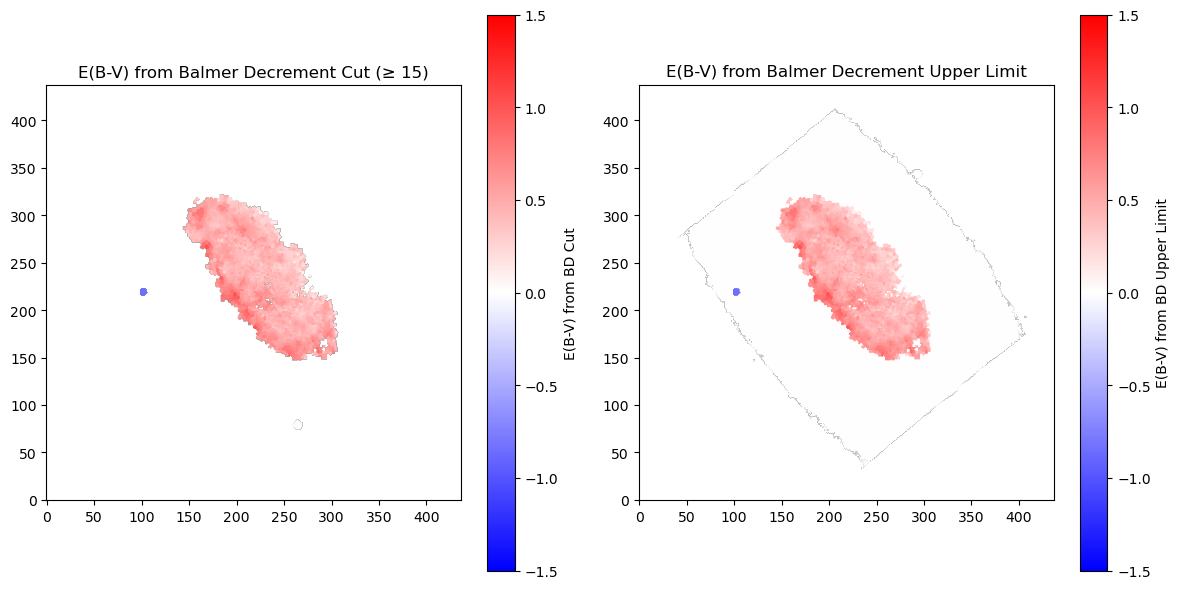

In [7]:
# Calzetti (2000) curve
def calzetti_curve(wavelengths):
    """Calzetti (2000) extinction curve."""
    # Convert single values to array
    if np.isscalar(wavelengths):
        wavelengths = np.array([wavelengths])
        
    # Calzetti (2000) parameters
    Rv = 4.05  # R_V for Calzetti law
    A_lambda = np.zeros_like(wavelengths, dtype=float)
    
    # Calculate the extinction for each wavelength
    mask_short = wavelengths < 6300
    
    # Short wavelengths
    A_lambda[mask_short] = 2.659 * (-2.156 + 1.509/wavelengths[mask_short] 
                                   - 0.198/wavelengths[mask_short]**2 
                                   + 0.011/wavelengths[mask_short]**3) + Rv
    # Long wavelengths
    A_lambda[~mask_short] = 2.659 * (-1.857 + 1.040/wavelengths[~mask_short]) + Rv
    
    return A_lambda[0] if np.isscalar(wavelengths) else A_lambda

# Calculate k values for Hβ and Hα
k_HB4861 = calzetti_curve(0.4861)  # Hβ
k_HA6562 = calzetti_curve(0.6562)  # Hα
k_OIII5006 = calzetti_curve(0.5006)  # [OIII] 5006
k_NII6583 = calzetti_curve(0.6583)  # [NII] 6583
k_SII6716 = calzetti_curve(0.6716)  # [SII] 6716
k_SII6730 = calzetti_curve(0.6730)  # [SII] 6730

R_int = 2.86

E_BV_BD_cut = 2.5/(k_HB4861 - k_HA6562) * np.log10( (HA6562_FLUX_cut/HB4861_FLUX_cut) / R_int )
E_BV_BD_upper = 2.5/(k_HB4861 - k_HA6562) * np.log10( BD_upper / R_int )

# Plot E_BV_BD_cut and E_BV_BD_upper maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(E_BV_BD_cut, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V) from BD Cut')
plt.title(f'E(B-V) from Balmer Decrement Cut (≥ {cut})')
plt.subplot(1, 2, 2)
plt.imshow(E_BV_BD_upper, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V) from BD Upper Limit')
plt.title('E(B-V) from Balmer Decrement Upper Limit')
plt.tight_layout()
plt.show()

In [8]:
HB4861_FLUX_upper = HB4861_FLUX * 10**(0.4 * k_HB4861 * E_BV_BD_upper)
HA6562_FLUX_upper = HA6562_FLUX * 10**(0.4 * k_HA6562 * E_BV_BD_upper)
OIII5006_FLUX_upper = OIII5006_FLUX * 10**(0.4 * k_OIII5006 * E_BV_BD_upper)
NII6583_FLUX_upper = NII6583_FLUX * 10**(0.4 * k_NII6583 * E_BV_BD_upper)
SII6716_FLUX_upper = SII6716_FLUX * 10**(0.4 * k_SII6716 * E_BV_BD_upper)
SII6730_FLUX_upper = SII6730_FLUX * 10**(0.4 * k_SII6730 * E_BV_BD_upper)


In [9]:
# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX_upper / HA6562_FLUX_upper)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX_upper+SII6730_FLUX_upper) / HA6562_FLUX_upper)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX_upper / HB4861_FLUX_upper)       # [O III]/Hβ         

mask_N2 = NII6583_FLUX_upper / NII6583_FLUX_ERR >= cut
mask_S2 = (SII6716_FLUX_upper + SII6730_FLUX_upper) / (SII6716_FLUX_ERR + SII6730_FLUX_ERR) >= cut
mask_O3 = OIII5006_FLUX_upper / OIII5006_FLUX_ERR >= cut
mask_combinedd = mask_combined & mask_N2 & mask_S2 & mask_O3

logN2_cut = np.where(mask_combinedd, logN2, np.nan)
logS2_cut = np.where(mask_combinedd, logS2, np.nan)
logO3_cut = np.where(mask_combinedd, logO3, np.nan)

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_4763/1526863589.py:4: RuntimeWarning: divide by zero encountered in divide
  logO3  = np.log10(OIII5006_FLUX_upper / HB4861_FLUX_upper)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_4763/1526863589.py:4: RuntimeWarning: invalid value encountered in divide
  logO3  = np.log10(OIII5006_FLUX_upper / HB4861_FLUX_upper)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_4763/1526863589.py:4: RuntimeWarning: divide by zero encountered in log10
  logO3  = np.log10(OIII5006_FLUX_upper / HB4861_FLUX_upper)       # [O III]/Hβ


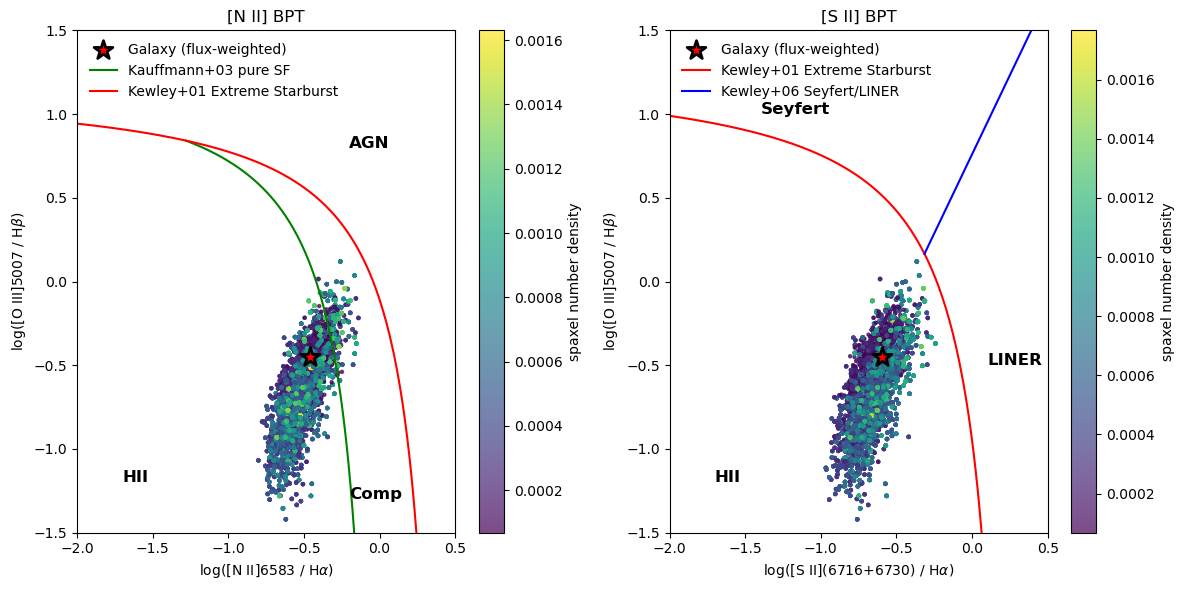

Galaxy flux-weighted representative points:
[N II] BPT: logN2 = -0.460, logO3 = -0.448
[S II] BPT: logS2 = -0.599, logO3 = -0.448
Number of spaxels in [N II] BPT regions:
HII: 25024, Comp: 18477, AGN: 38568
Number of spaxels in [S II] BPT regions:
HII: 35249, Seyfert: 21591, LINER: 16269


In [10]:
#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76        

# Calculate flux-weighted galaxy representative points
# Assuming you have a flux array (replace 'flux' with your actual flux variable name)
# If you don't have flux, you can use Ha_flux or another appropriate flux measurement
valid_mask_N2 = np.isfinite(logN2_cut) & np.isfinite(logO3_cut) 
valid_mask_S2 = np.isfinite(logS2_cut) & np.isfinite(logO3_cut) 

# Calculate flux-weighted representative points
galaxy_logN2 = np.log10(np.nansum(10**logN2_cut[valid_mask_N2] * 10**logN2_cut[valid_mask_N2]) / np.nansum(10**logN2_cut[valid_mask_N2]))
galaxy_logO3_N2 = np.log10(np.nansum(10**logO3_cut[valid_mask_N2] * 10**logO3_cut[valid_mask_N2]) / np.nansum(10**logO3_cut[valid_mask_N2]))
galaxy_logS2 = np.log10(np.nansum(10**logS2_cut[valid_mask_S2] * 10**logS2_cut[valid_mask_S2]) / np.nansum(10**logS2_cut[valid_mask_S2]))
galaxy_logO3_S2 = np.log10(np.nansum(10**logO3_cut[valid_mask_S2] * 10**logO3_cut[valid_mask_S2]) / np.nansum(10**logO3_cut[valid_mask_S2]))

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# --- NII BPT -------------------------------------------------------
x = logN2_cut; y = logO3_cut
# Create a 2D histogram to get density information
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=1000)
# Assign density values to each point
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[0].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[0], label='spaxel number density')

# Add flux-weighted galaxy point
ax[0].scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

xg = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
ax[0].plot(xg, kauff03_N2(xg), 'g-', lw=1.5, label='Kauffmann+03 pure SF')
xr = np.linspace(-2.0, 0.3, 200)
ax[0].plot(xr, kewley01_N2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
ax[0].set_xlabel(r'log([N II]6583 / H$\alpha$)')
ax[0].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[0].set_xlim(-2.0, 0.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title('[N II] BPT')
ax[0].legend(frameon=False, loc='upper left')

# Add annotations for NII BPT
ax[0].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[0].text(-0.2, -1.3, 'Comp', fontsize=12, fontweight='bold')
ax[0].text(-0.2, 0.8, 'AGN', fontsize=12, fontweight='bold')

# --- SII BPT -------------------------------------------------------
x = logS2_cut; y = logO3_cut
# Create a 2D histogram for S II BPT
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=1000)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[1].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[1], label='spaxel number density')

# Add flux-weighted galaxy point
ax[1].scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

ax[1].plot(xr, kewley01_S2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
xb = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)
ax[1].plot(xb, kewley06_Sy_LIN(xb), 'b-', lw=1.5, label='Kewley+06 Seyfert/LINER')
ax[1].set_xlabel(r'log([S II](6716+6730) / H$\alpha$)')
ax[1].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[1].set_xlim(-2.0, 0.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_title('[S II] BPT')
ax[1].legend(frameon=False)

# Add annotations for SII BPT
ax[1].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[1].text(-1.4, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
ax[1].text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')

plt.tight_layout(); plt.show()

# Print galaxy representative points
print(f"Galaxy flux-weighted representative points:")
print(f"[N II] BPT: logN2 = {galaxy_logN2:.3f}, logO3 = {galaxy_logO3_N2:.3f}")
print(f"[S II] BPT: logS2 = {galaxy_logS2:.3f}, logO3 = {galaxy_logO3_S2:.3f}")

# Count the number of spaxels in each region
N2_HII = logO3 <= kauff03_N2(logN2)
N2_Comp = (logO3 > kauff03_N2(logN2)) & (logO3 <= kewley01_N2(logN2))
N2_AGN = logO3 > kewley01_N2(logN2)
S2_HII = logO3 <= kewley01_S2(logS2)
S2_Seyfert = (logO3 > kewley01_S2(logS2)) & (logO3 > kewley06_Sy_LIN(logS2))
S2_LINER = (logO3 > kewley01_S2(logS2)) & (logO3 <= kewley06_Sy_LIN(logS2))
# Count the number of spaxels in each region
N2_HII_count = np.sum(N2_HII)
N2_Comp_count = np.sum(N2_Comp)
N2_AGN_count = np.sum(N2_AGN)
S2_HII_count = np.sum(S2_HII)
S2_Seyfert_count = np.sum(S2_Seyfert)
S2_LINER_count = np.sum(S2_LINER)
print(f"Number of spaxels in [N II] BPT regions:")
print(f"HII: {N2_HII_count}, Comp: {N2_Comp_count}, AGN: {N2_AGN_count}")
print(f"Number of spaxels in [S II] BPT regions:")
print(f"HII: {S2_HII_count}, Seyfert: {S2_Seyfert_count}, LINER: {S2_LINER_count}")

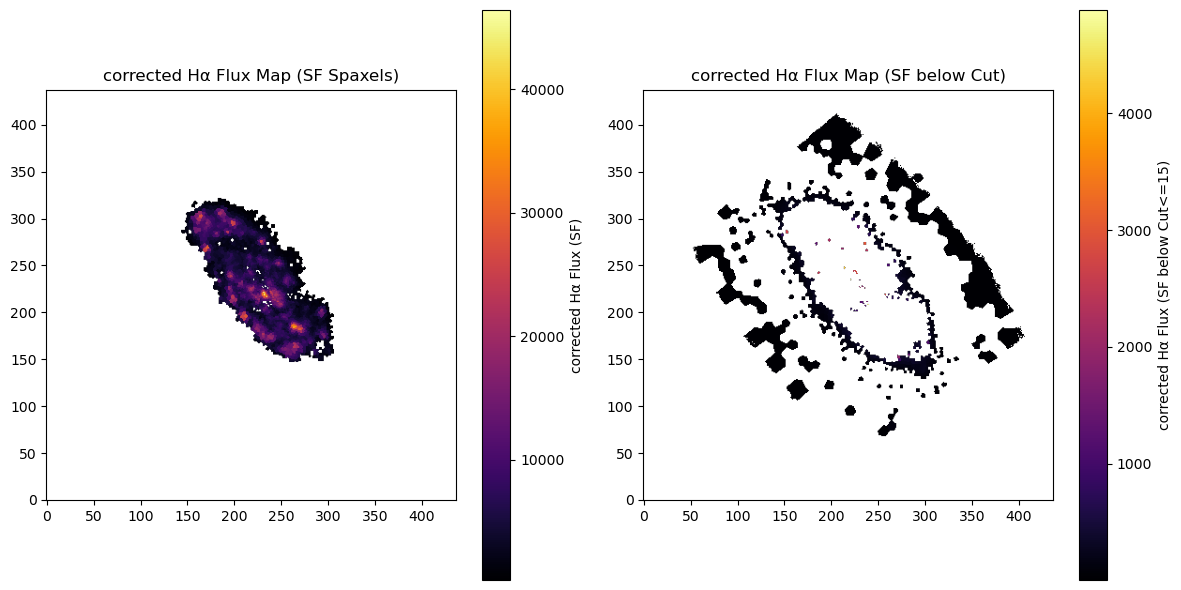

In [11]:
# Purely SF spaxels in both BPT diagram
mask_SF = (N2_HII+N2_Comp) & (S2_HII)

# Apply the mask to the flux maps
HB4861_FLUX_SF = np.where(mask_SF*mask_combinedd, HB4861_FLUX_upper, np.nan)
HA6562_FLUX_SF = np.where(mask_SF*mask_combinedd, HA6562_FLUX_upper, np.nan)
OIII5006_FLUX_SF = np.where(mask_SF*mask_combinedd, OIII5006_FLUX_upper, np.nan)
NII6583_FLUX_SF = np.where(mask_SF*mask_combinedd, NII6583_FLUX_upper, np.nan)
SII6716_FLUX_SF = np.where(mask_SF*mask_combinedd, SII6716_FLUX_upper, np.nan)
SII6730_FLUX_SF = np.where(mask_SF*mask_combinedd, SII6730_FLUX_upper, np.nan)

HB4861_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), HB4861_FLUX_upper, np.nan)
HA6562_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), HA6562_FLUX_upper, np.nan)
OIII5006_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), OIII5006_FLUX_upper, np.nan)
NII6583_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), NII6583_FLUX_upper, np.nan)
SII6716_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), SII6716_FLUX_upper, np.nan)
SII6730_FLUX_out_SF = np.where(mask_SF*(~mask_combinedd), SII6730_FLUX_upper, np.nan)

# Plot HA6562_FLUX_SF and HA6562_FLUX_upper maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(HA6562_FLUX_SF, origin='lower', cmap='inferno')
plt.colorbar(label='corrected Hα Flux (SF)')
plt.title('corrected Hα Flux Map (SF Spaxels)')
plt.subplot(1, 2, 2)
plt.imshow(HA6562_FLUX_out_SF, origin='lower', cmap='inferno')
plt.colorbar(label=f'corrected Hα Flux (SF below Cut<={cut})')
plt.title('corrected Hα Flux Map (SF below Cut)')
plt.tight_layout()
plt.show()

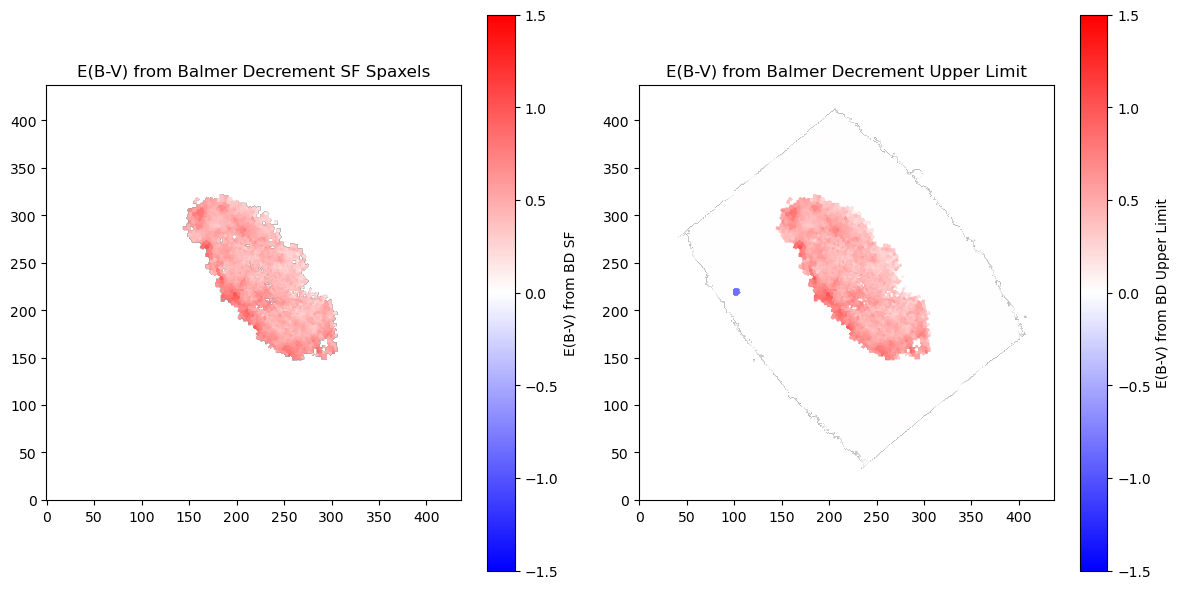

Lowest Balmer Decrement: 3.30392403493291
Highest Balmer Decrement: 9.36650837704988
Lowest 5 unique non-NaN Balmer Decrement values: [3.30392403 3.36332766 3.4525239  3.4888582  3.500445  ]


In [12]:
BD_SF = np.where(mask_SF*mask_combinedd, BD_upper, np.nan)
E_BV_BD_SF = np.where(mask_SF*mask_combinedd, E_BV_BD_upper, np.nan)



# Plot E_BV_BD_SF and E_BV_BD_upper maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(E_BV_BD_SF, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V) from BD SF')
plt.title('E(B-V) from Balmer Decrement SF Spaxels')
plt.subplot(1, 2, 2)
plt.imshow(E_BV_BD_upper, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V) from BD Upper Limit')
plt.title('E(B-V) from Balmer Decrement Upper Limit')
plt.tight_layout()
plt.show()

# Print the lowest and highest values of the Balmer decrement map
print(f"Lowest Balmer Decrement: {np.nanmin(BD_SF)}")
print(f"Highest Balmer Decrement: {np.nanmax(BD_SF)}")
# Print lowest 5 non-NaN values (unique values only)
bd_SF_valid = BD_SF[np.isfinite(BD_SF)]
bd_SF_unique = np.unique(bd_SF_valid)
lowest_5_SF_unique = bd_SF_unique[:5]
print(f"Lowest 5 unique non-NaN Balmer Decrement values: {lowest_5_SF_unique}")

Total luminosity of Hα (corrected): 3.197e+40 erg / s erg/s
Total luminosity of Hα (SF spaxels): 3.088e+40 erg / s erg/s


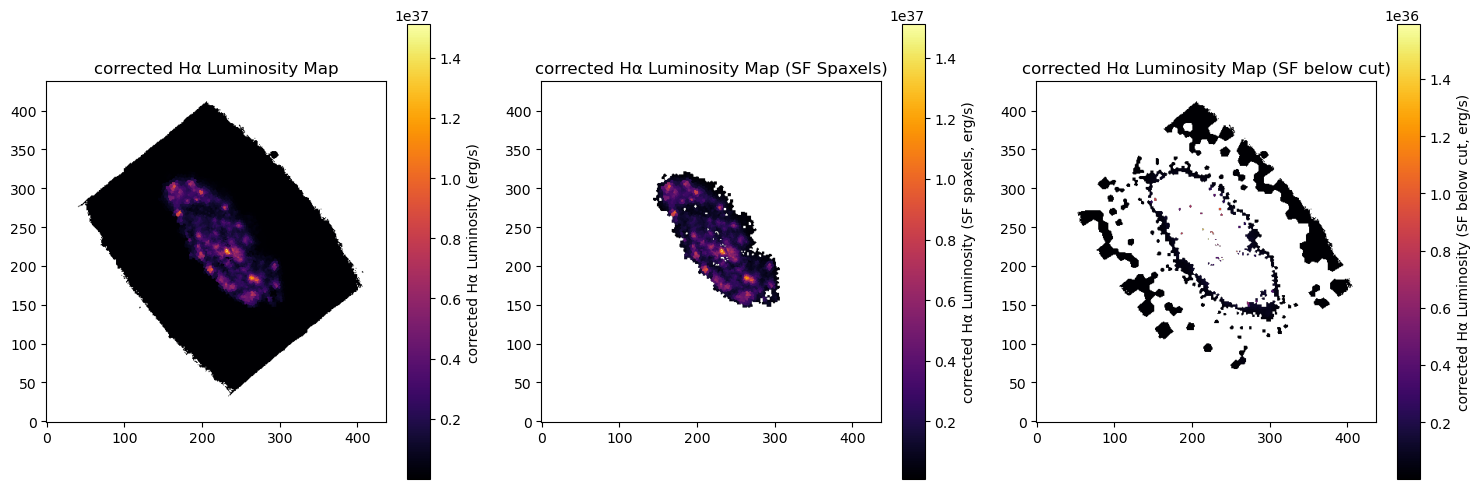

In [13]:
# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs

# Calculate luminosity for all the flux maps
lum_HB4861_upper = flux_to_luminosity(HB4861_FLUX_upper)
lum_HA6562_upper = flux_to_luminosity(HA6562_FLUX_upper)
lum_OIII5006_upper = flux_to_luminosity(OIII5006_FLUX_upper)
lum_NII6583_upper = flux_to_luminosity(NII6583_FLUX_upper)
lum_SII6716_upper = flux_to_luminosity(SII6716_FLUX_upper)
lum_SII6730_upper = flux_to_luminosity(SII6730_FLUX_upper)

lum_HB4861_SF = flux_to_luminosity(HB4861_FLUX_SF)
lum_HA6562_SF = flux_to_luminosity(HA6562_FLUX_SF)
lum_OIII5006_SF = flux_to_luminosity(OIII5006_FLUX_SF)
lum_NII6583_SF = flux_to_luminosity(NII6583_FLUX_SF)
lum_SII6716_SF = flux_to_luminosity(SII6716_FLUX_SF)
lum_SII6730_SF = flux_to_luminosity(SII6730_FLUX_SF)

lum_HB4861_out_SF = flux_to_luminosity(HB4861_FLUX_out_SF)
lum_HA6562_out_SF = flux_to_luminosity(HA6562_FLUX_out_SF)
lum_OIII5006_out_SF = flux_to_luminosity(OIII5006_FLUX_out_SF)
lum_NII6583_out_SF = flux_to_luminosity(NII6583_FLUX_out_SF)    
lum_SII6716_out_SF = flux_to_luminosity(SII6716_FLUX_out_SF)
lum_SII6730_out_SF = flux_to_luminosity(SII6730_FLUX_out_SF)

total_lum_HA6562_upper = np.nansum(lum_HA6562_upper)
total_lum_HA6562_SF = np.nansum(lum_HA6562_SF)

print(f"Total luminosity of Hα (corrected): {total_lum_HA6562_upper:.3e} erg/s")
print(f"Total luminosity of Hα (SF spaxels): {total_lum_HA6562_SF:.3e} erg/s")
# Plot the corrected Halpha luminosity maps (all three)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lum_HA6562_upper.value, origin='lower', cmap='inferno')
plt.colorbar(label='corrected Hα Luminosity (erg/s)')
plt.title('corrected Hα Luminosity Map')

plt.subplot(1, 3, 2)
plt.imshow(lum_HA6562_SF.value, origin='lower', cmap='inferno')
plt.colorbar(label='corrected Hα Luminosity (SF spaxels, erg/s)')
plt.title('corrected Hα Luminosity Map (SF Spaxels)')

plt.subplot(1, 3, 3)
plt.imshow(lum_HA6562_out_SF.value, origin='lower', cmap='inferno')
plt.colorbar(label='corrected Hα Luminosity (SF below cut, erg/s)')
plt.title('corrected Hα Luminosity Map (SF below cut)')

plt.tight_layout()
plt.show()

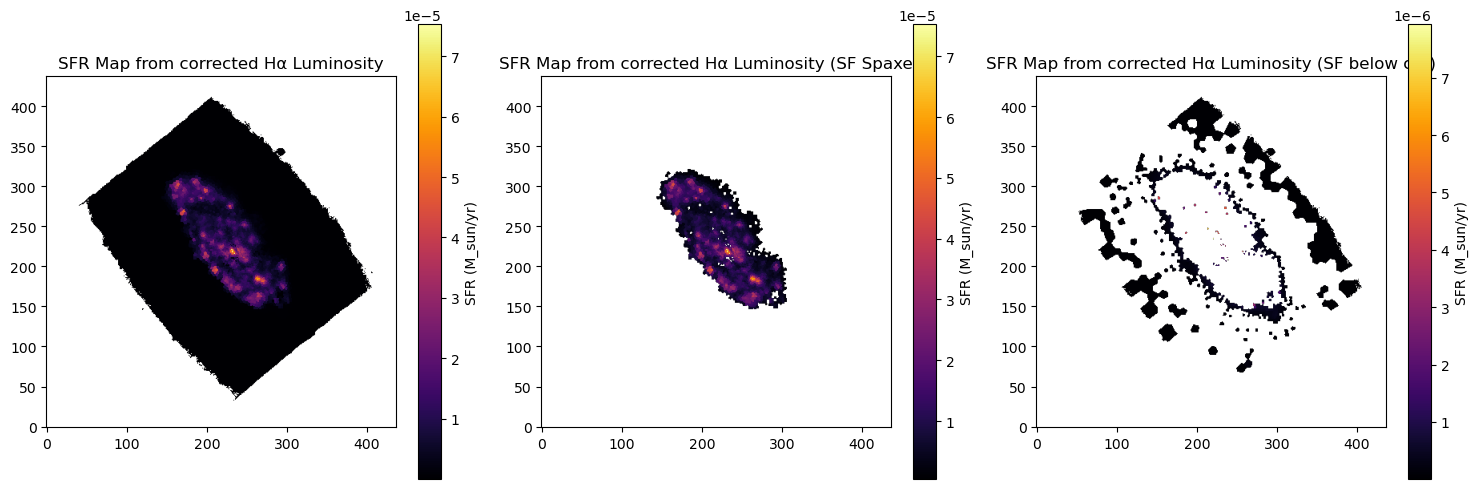

In [14]:
# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity.cgs.value / 0.67 *0.63 # SFR in M_sun/yr

# Calculate SFR for all the Halpha maps
sfr_HA6562_upper = calzetti_sfr(lum_HA6562_upper)
sfr_HA6562_SF = calzetti_sfr(lum_HA6562_SF)
sfr_HA6562_out_SF = calzetti_sfr(lum_HA6562_out_SF)
# Plot the SFR maps
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sfr_HA6562_upper, origin='lower', cmap='inferno')
plt.colorbar(label='SFR (M_sun/yr)')
plt.title('SFR Map from corrected Hα Luminosity')
plt.subplot(1, 3, 2)
plt.imshow(sfr_HA6562_SF, origin='lower', cmap='inferno')
plt.colorbar(label='SFR (M_sun/yr)')
plt.title('SFR Map from corrected Hα Luminosity (SF Spaxels)')
plt.subplot(1, 3, 3)
plt.imshow(sfr_HA6562_out_SF, origin='lower', cmap='inferno')
plt.colorbar(label='SFR (M_sun/yr)')
plt.title('SFR Map from corrected Hα Luminosity (SF below cut)')
plt.tight_layout()
plt.show()

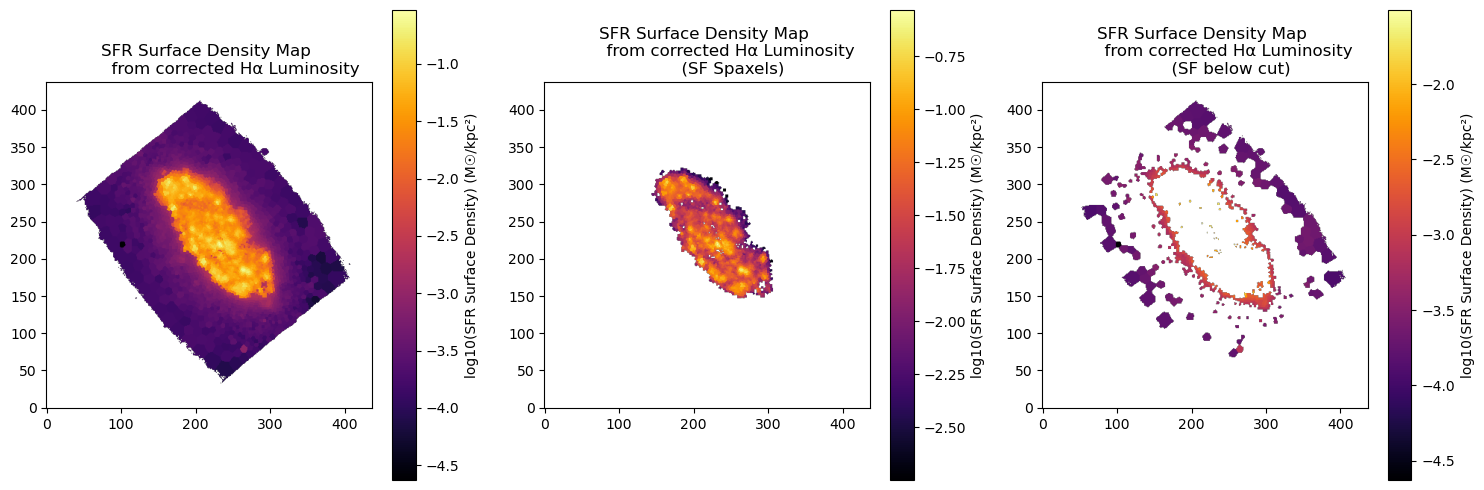

In [15]:
# Getting the SFR surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(gas_header).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert SFR to surface density
sfr_surface_density_HA6562_upper = sfr_HA6562_upper / pixel_area_kpc.value
sfr_surface_density_HA6562_SF = sfr_HA6562_SF / pixel_area_kpc.value
sfr_surface_density_HA6562_out_SF = sfr_HA6562_out_SF / pixel_area_kpc.value
# 3. Convert to log10 scale
log_sfr_surface_density_HA6562_upper = np.log10(sfr_surface_density_HA6562_upper)
log_sfr_surface_density_HA6562_SF = np.log10(sfr_surface_density_HA6562_SF)
log_sfr_surface_density_HA6562_out_SF = np.log10(sfr_surface_density_HA6562_out_SF)
# Plot the SFR surface density maps
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(log_sfr_surface_density_HA6562_upper, origin='lower', cmap='inferno')
plt.colorbar(label='log10(SFR Surface Density) (M☉/kpc²)')
plt.title('''SFR Surface Density Map 
          from corrected Hα Luminosity''')
plt.subplot(1, 3, 2)
plt.imshow(log_sfr_surface_density_HA6562_SF, origin='lower', cmap='inferno')
plt.colorbar(label='log10(SFR Surface Density) (M☉/kpc²)')
plt.title('''SFR Surface Density Map 
          from corrected Hα Luminosity 
          (SF Spaxels)''')
plt.subplot(1, 3, 3)    
plt.imshow(log_sfr_surface_density_HA6562_out_SF, origin='lower', cmap='inferno')
plt.colorbar(label='log10(SFR Surface Density) (M☉/kpc²)')
plt.title('''SFR Surface Density Map 
          from corrected Hα Luminosity 
          (SF below cut)''')
plt.tight_layout()
plt.show()

In [16]:
binning_path = Path('IC3392_SPATIAL_BINNING_maps_extended.fits')
print(f"Loading kinematic map from {binning_path}")
with fits.open(binning_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")

Loading kinematic map from IC3392_SPATIAL_BINNING_maps_extended.fits
Filename: IC3392_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (437, 438)   float64   
  8  ML_R          1 ImageHDU        27   (437, 438)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (437, 438)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (437, 438)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (437, 438)   float64   
 12  MAGNITUDE_R_UNCORREC

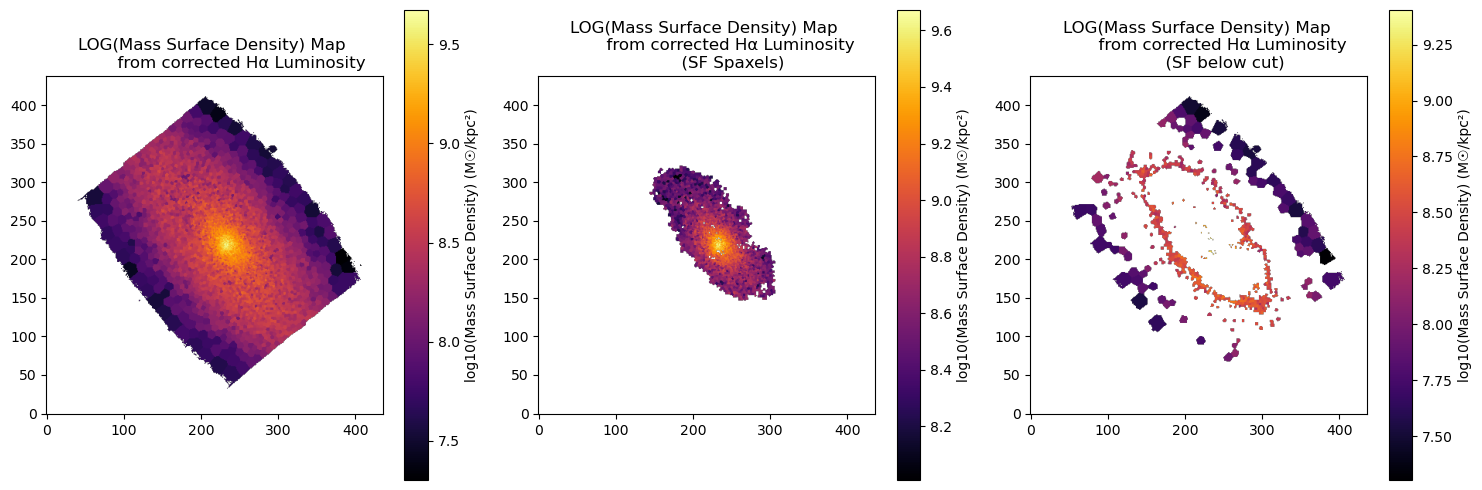

In [17]:
LOGMASS_SURFACE_DENSITY_upper = LOGMASS_SURFACE_DENSITY
LOGMASS_SURFACE_DENSITY_SF = np.where(mask_SF*mask_combinedd, LOGMASS_SURFACE_DENSITY, np.nan)
LOGMASS_SURFACE_DENSITY_out_SF = np.where(mask_SF*(~mask_combinedd), LOGMASS_SURFACE_DENSITY, np.nan)

# Plot LOGMASS_SURFACE_DENSITY_upper, LOGMASS_SURFACE_DENSITY_SF, LOGMASS_SURFACE_DENSITY_out_SF
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(LOGMASS_SURFACE_DENSITY_upper, origin='lower', cmap='inferno')
plt.colorbar(label='log10(Mass Surface Density) (M☉/kpc²)')
plt.title('''LOG(Mass Surface Density) Map 
          from corrected Hα Luminosity''')
plt.subplot(1, 3, 2)
plt.imshow(LOGMASS_SURFACE_DENSITY_SF, origin='lower', cmap='inferno')
plt.colorbar(label='log10(Mass Surface Density) (M☉/kpc²)')
plt.title('''LOG(Mass Surface Density) Map 
          from corrected Hα Luminosity 
          (SF Spaxels)''')
plt.subplot(1, 3, 3)    
plt.imshow(LOGMASS_SURFACE_DENSITY_out_SF, origin='lower', cmap='inferno')
plt.colorbar(label='log10(Mass Surface Density) (M☉/kpc²)')
plt.title('''LOG(Mass Surface Density) Map 
          from corrected Hα Luminosity 
          (SF below cut)''')
plt.tight_layout()
plt.show()



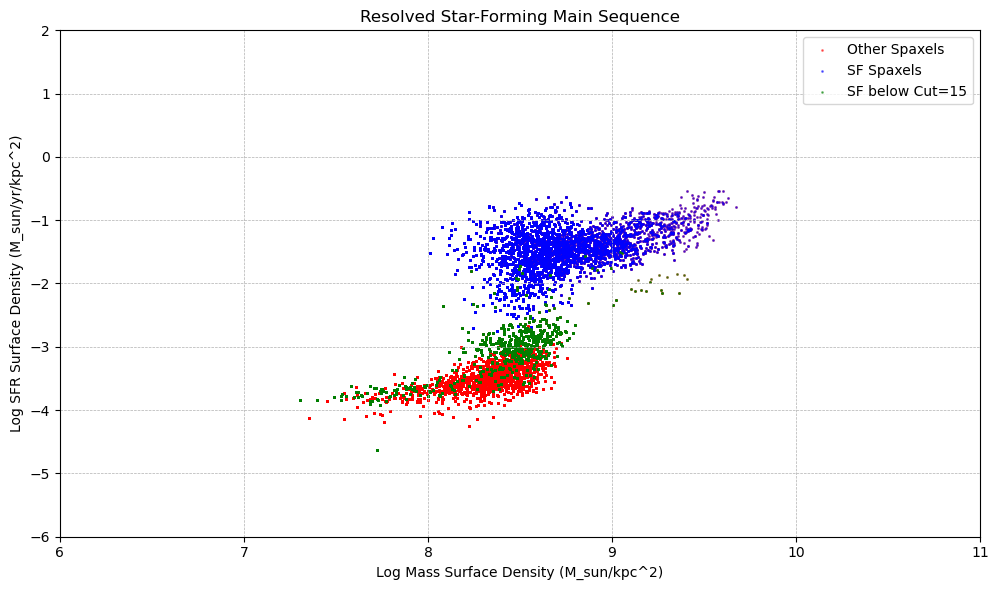

In [18]:
# Plot the resolved SFMS plot
plt.figure(figsize=(10, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY_upper,
            log_sfr_surface_density_HA6562_upper, s=1, alpha=0.5, color='red', label='Other Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY_SF,
            log_sfr_surface_density_HA6562_SF, s=1, alpha=0.5, color='blue', label='SF Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY_out_SF,
            log_sfr_surface_density_HA6562_out_SF, s=1, alpha=0.5, color='green', label=f'SF below Cut={cut}')
plt.legend()
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.show()

SF Spaxels: 14720 valid points
SF Linear fit: slope=0.447, intercept=-5.388, R²=0.088
SF 95% Contour level: 0.107391
SF 95% contour created with 1 levels
SF below Cut: 17865 valid points
SF below Cut 95% Contour level: 0.168289
SF below Cut 95% contour created with 1 levels


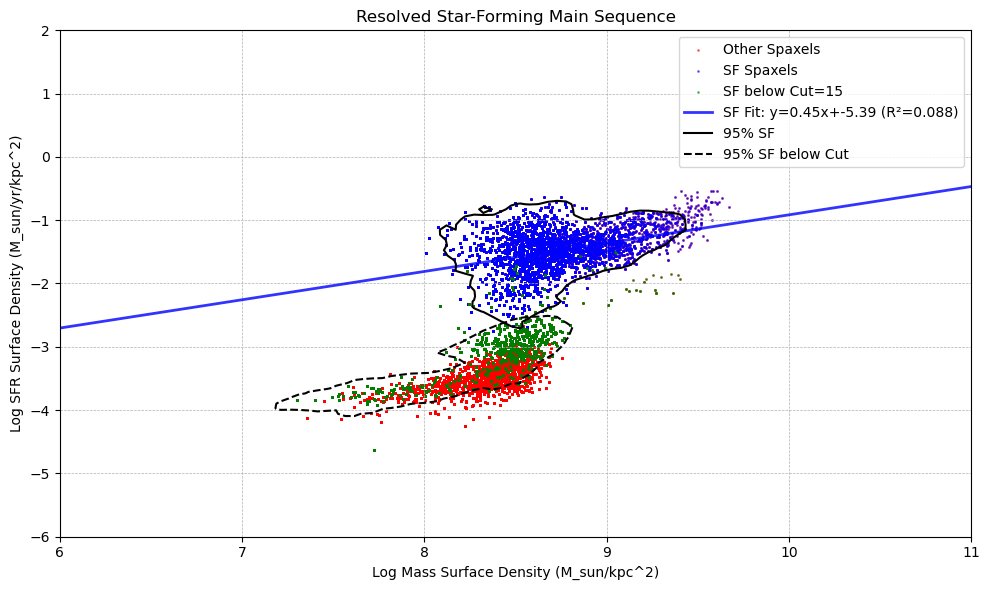

In [19]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats

# Configuration
CONTOUR_PERCENTAGE = 95  # Change this value to adjust contour level (e.g., 68, 90, 95, 99)

# Plot the resolved SFMS plot
plt.figure(figsize=(10, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY_upper,
            log_sfr_surface_density_HA6562_upper, s=1, alpha=0.5, color='red', label='Other Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY_SF,
            log_sfr_surface_density_HA6562_SF, s=1, alpha=0.5, color='blue', label='SF Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY_out_SF,
            log_sfr_surface_density_HA6562_out_SF, s=1, alpha=0.5, color='green', label=f'SF below Cut={cut}')

# Create grid for contour calculation (define once)
x_min, x_max = 6, 11
y_min, y_max = -6, 2
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Storage for legend elements
legend_elements = []

def calculate_density_levels(kde_values, percentages=[CONTOUR_PERCENTAGE]):
    """Calculate density levels that enclose given percentages of the data"""
    # Sort KDE values in descending order
    sorted_values = np.sort(kde_values.ravel())[::-1]
    
    # Calculate cumulative sum (normalized)
    cumsum = np.cumsum(sorted_values)
    cumsum = cumsum / cumsum[-1]
    
    levels = []
    for pct in percentages:
        # Find the density level that encloses pct% of the probability mass
        idx = np.where(cumsum >= pct / 100)[0]
        if len(idx) > 0:
            levels.append(sorted_values[idx[0]])
        else:
            levels.append(np.max(sorted_values) * 0.1)  # fallback
    
    return levels

# Add contours for SF Spaxels
mask_sf = (np.isfinite(LOGMASS_SURFACE_DENSITY_SF) & 
           np.isfinite(log_sfr_surface_density_HA6562_SF) &
           ~np.isnan(LOGMASS_SURFACE_DENSITY_SF) & 
           ~np.isnan(log_sfr_surface_density_HA6562_SF))
mass_sf_clean = LOGMASS_SURFACE_DENSITY_SF[mask_sf]
sfr_sf_clean = log_sfr_surface_density_HA6562_SF[mask_sf]

print(f"SF Spaxels: {len(mass_sf_clean)} valid points")

# Fit a line to the blue dots (SF Spaxels)
if len(mass_sf_clean) > 10:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(mass_sf_clean, sfr_sf_clean)
    
    # Create line for plotting
    x_line = np.linspace(x_min, x_max, 100)
    y_line = slope * x_line + intercept
    
    # Plot the fit line
    plt.plot(x_line, y_line, color='blue', linewidth=2, linestyle='-', alpha=0.8, 
             label=f'SF Fit: y={slope:.2f}x+{intercept:.2f} (R²={r_value**2:.3f})')
    
    print(f"SF Linear fit: slope={slope:.3f}, intercept={intercept:.3f}, R²={r_value**2:.3f}")

if len(mass_sf_clean) > 50:
    xy_sf = np.vstack([mass_sf_clean, sfr_sf_clean])
    try:
        kde_sf = gaussian_kde(xy_sf)
        
        # Calculate KDE values
        f_sf = np.reshape(kde_sf(positions).T, xx.shape)
        
        # Calculate density level
        levels_sf = calculate_density_levels(f_sf, [CONTOUR_PERCENTAGE])
        level = levels_sf[0]
        
        print(f"SF {CONTOUR_PERCENTAGE}% Contour level: {level:.6f}")
        
        # Plot contour in black
        cs_sf = plt.contour(xx, yy, f_sf, levels=[level], colors='black', linewidths=1.5, linestyles='-')
        
        print(f"SF {CONTOUR_PERCENTAGE}% contour created with {len(cs_sf.levels)} levels")
        
        # Add to legend
        legend_elements.append(
            Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label=f'{CONTOUR_PERCENTAGE}% SF')
        )
        
    except Exception as e:
        print(f"Could not compute contours for SF Spaxels: {e}")

# Add contours for SF below Cut
mask_out_sf = (np.isfinite(LOGMASS_SURFACE_DENSITY_out_SF) & 
               np.isfinite(log_sfr_surface_density_HA6562_out_SF) &
               ~np.isnan(LOGMASS_SURFACE_DENSITY_out_SF) & 
               ~np.isnan(log_sfr_surface_density_HA6562_out_SF))
mass_out_sf_clean = LOGMASS_SURFACE_DENSITY_out_SF[mask_out_sf]
sfr_out_sf_clean = log_sfr_surface_density_HA6562_out_SF[mask_out_sf]

print(f"SF below Cut: {len(mass_out_sf_clean)} valid points")

if len(mass_out_sf_clean) > 50:
    xy_out_sf = np.vstack([mass_out_sf_clean, sfr_out_sf_clean])
    try:
        kde_out_sf = gaussian_kde(xy_out_sf)
        
        # Calculate KDE values
        f_out_sf = np.reshape(kde_out_sf(positions).T, xx.shape)
        
        # Calculate density level
        levels_out_sf = calculate_density_levels(f_out_sf, [CONTOUR_PERCENTAGE])
        level = levels_out_sf[0]
        
        print(f"SF below Cut {CONTOUR_PERCENTAGE}% Contour level: {level:.6f}")
        
        # Plot contour in black
        cs_out_sf = plt.contour(xx, yy, f_out_sf, levels=[level], colors='black', linewidths=1.5, linestyles='--')
        
        print(f"SF below Cut {CONTOUR_PERCENTAGE}% contour created with {len(cs_out_sf.levels)} levels")
        
        # Add to legend
        legend_elements.append(
            Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label=f'{CONTOUR_PERCENTAGE}% SF below Cut')
        )
        
    except Exception as e:
        print(f"Could not compute contours for SF below Cut: {e}")

# Create combined legend
handles, labels = plt.gca().get_legend_handles_labels()
all_handles = handles + legend_elements
plt.legend(handles=all_handles, loc='best')

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.show()